<a href="https://colab.research.google.com/github/TehilaC/Expert-Ranking-Algorithm-in-Online-Communities/blob/main/Analyze_Reddit_20240814.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**כניסה לגוגל**

In [306]:
#from google.colab import auth
#auth.authenticate_user()

In [307]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import zscore

import matplotlib.pyplot as plt
from networkx import Graph

from urllib.request import urlopen
from bs4 import BeautifulSoup

import codecs

*   Get posts & comments data from BigQuery
*   Save merge df




In [308]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

# Authenticate to BigQuery
credentials = service_account.Credentials.from_service_account_file(
    '/content/savvy-night-308317-be1fc47939da.json'
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Define queries to get the necessary data
posts_query = """
select id, title, selftext, ups, downs, subreddit, author, author_fullname, DATETIME(TIMESTAMP_SECONDS(cast(created_utc as int64))) AS datetime_utc, num_comments, num_crossposts, num_reports, score
from `savvy-night-308317.reddit.Posts_clean`
"""

comments_query = """
select id, link_id , body , parent_id, ups, downs, subreddit, author, author_fullname, DATETIME(TIMESTAMP_SECONDS(cast(created_utc as int64))) AS datetime_utc,score
from `savvy-night-308317.reddit.Comments_clean`
"""

# Execute queries
posts_df_source = client.query(posts_query).to_dataframe()
comments_df_source = client.query(comments_query).to_dataframe()

# Merging comments with their respective posts
# Extract the post ID from the link_id in comments
comments_df_source['post_id'] = comments_df_source['link_id'].str.extract(r't3_(.*)')

# Initialize a column for post_id in comments_df to track the original post for subcomments
comments_df_source['original_comment_id'] = comments_df_source['parent_id'].str.extract(r't1_(.*)')

In [309]:
year = 2013
subrredit = 'Python'
#subrredit = 'learnpython'

In [310]:
posts_df = posts_df_source[posts_df_source['subreddit'].apply(lambda x: x == subrredit )]
comments_df = comments_df_source[ comments_df_source['subreddit'].apply(lambda x: x == subrredit )]
posts_df = posts_df.loc[(posts_df['datetime_utc'].dt.year >= 2015 )& (posts_df['datetime_utc'].dt.year<= 2023 )]

comments_df.loc[:, 'author_fullname'] = comments_df['author_fullname'].fillna(comments_df['author'])
posts_df.loc[:, 'author_fullname'] = posts_df['author_fullname'].fillna(posts_df['author'])

In [311]:
#remove [delete] users
comments_df = comments_df[comments_df['author_fullname'] != '[deleted]']
posts_df = posts_df[posts_df['author_fullname'] != '[deleted]']

Merge posts and commens

In [312]:
# Merge comments with posts
merged_df = comments_df.merge(posts_df, left_on='post_id', right_on='id', suffixes=('_comment', '_post'))

In [360]:
edge_list = merged_df[[ 'author_post', 'author_fullname_post', 'author_comment', 'author_fullname_comment'
                       , 'score_comment' , 'score_post' ,'id_post', 'id_comment']]

Cleaning

In [361]:
posts_df = posts_df.drop_duplicates()
comments_df = comments_df.drop_duplicates()
edge_list = edge_list.dropna()

In [362]:
# delete all selfeloop edges
print( len(edge_list) )
edge_list = edge_list[edge_list['author_fullname_post'] != edge_list['author_fullname_comment']]
print( len(edge_list) )

729203
617577


Create **users** df:


*   Only active users
*   no duplicates
*   Additional data:
    *  Posts : num of posts, sum of all scores
    *  Comments : num of comments, sum of all comments, unique count of askers

In [363]:
# set up negative values
def non_negative_edges():
  min_score = edge_list['score_comment'].min()
  print("min_score: ", min_score)
  if min_score < 0:
      abs_min_score = abs(min_score) + 1
      print("abs_min_score: ", abs_min_score)
      edge_list['score_comment_pos'] = edge_list['score_comment'] + abs_min_score

non_negative_edges()

min_score:  -556.0
abs_min_score:  557.0


In [364]:
all_users = pd.concat([posts_df["author_fullname"], comments_df["author_fullname"]]).reset_index(name='author_fullname')
#all_users = pd.concat([edge_list['author_fullname_post'], edge_list['author_fullname_comment']]).reset_index(name='author_fullname')
all_users.drop_duplicates()

# add scores - calculate karama
post_score_sum = edge_list.groupby('author_fullname_post').agg({
    'score_post': 'sum',
    'id_post': 'nunique'
}).rename(columns={
    'id_post': 'count_unique_posts',
    'score_post': 'post_score_sum'
}).reset_index()
all_users = all_users.merge(post_score_sum, how='left', left_on='author_fullname', right_on='author_fullname_post')

comments_score_sum = edge_list.groupby('author_fullname_comment').agg({
    'score_comment': 'sum',
    'score_comment_pos': 'sum',
    'id_comment': 'nunique',
    'author_fullname_post': 'nunique'
}).rename(columns={
    'score_comment': 'comments_score_sum',
    'score_comment_pos': 'comments_score_sum_pos',
    'id_comment': 'count_unique_comment',
    'author_fullname_post': 'count_unique_posts_asker'
}).reset_index()

all_users = all_users.merge(comments_score_sum, how='left', left_on='author_fullname', right_on='author_fullname_comment')
all_users.fillna(0, inplace=True)

# calclulate karama for user
all_users['karama'] = all_users['post_score_sum'] + all_users['comments_score_sum']

In [365]:
all_users.reset_index(drop=True, inplace=True)
all_users = all_users.drop_duplicates(subset = 'author_fullname')

print(len(all_users))

213199


In [366]:
edges_list_grouped = edge_list.groupby(['author_fullname_comment', 'author_fullname_post'])['score_comment'].sum().reset_index(name='score_comment')

# set up negative values
def non_negative_edges_total():
  min_score = edges_list_grouped['score_comment'].min()
  print("min_score: ", min_score)
  if min_score < 0:
      abs_min_score = abs(min_score) + 1
      print("abs_min_score: ", abs_min_score)
      edges_list_grouped['score_comment'] = edges_list_grouped['score_comment'] + abs_min_score

#non_negative_edges_total()

edges_l = edges_list_grouped[['author_fullname_post', 'author_fullname_comment', 'score_comment']].values.tolist()


In [367]:
edges_list_grouped.to_csv('edges_test.csv')

In [368]:
edges_list_grouped_corr = edges_list_grouped.groupby(['author_fullname_comment'])['score_comment'].sum().reset_index(name='score_comment_corr')
all_users = all_users.merge(edges_list_grouped_corr, how='left', left_on='author_fullname', right_on='author_fullname_comment')
all_users.fillna(0, inplace=True)

In [369]:
all_users.head()

,index,author_fullname,author_fullname_post,post_score_sum,count_unique_posts,author_fullname_comment_x,comments_score_sum,comments_score_sum_pos,count_unique_comment,count_unique_posts_asker,karama,author_fullname_comment_y,score_comment_corr
0,0,t2_7ogw5,t2_7ogw5,519610.0,315.0,t2_7ogw5,6.0,563.0,1.0,1.0,519616.0,t2_7ogw5,6.0
1,1,t2_azskf4p,t2_azskf4p,266.0,2.0,t2_azskf4p,5.0,2790.0,5.0,2.0,271.0,t2_azskf4p,5.0
2,2,t2_c1qhwo8c,t2_c1qhwo8c,84.0,5.0,0,0.0,0.0,0.0,0.0,84.0,0,0.0
3,3,t2_27zm0l8g,t2_27zm0l8g,264376.0,105.0,t2_27zm0l8g,104.0,26283.0,47.0,14.0,264480.0,t2_27zm0l8g,104.0
4,4,t2_zia33,t2_zia33,11.0,1.0,0,0.0,0.0,0.0,0.0,11.0,0,0.0


Create Graph

In [370]:
print( "users: " , len(all_users))
print( "posts: " , len(posts_df))
print( "comments: " , len(comments_df))
print( "edge_list: " , len(edge_list) )
print( "merge: " , len(merged_df) )

users:  213199
posts:  140288
comments:  1039729
edge_list:  617577
merge:  729203


In [371]:
#G=nx.MultiDiGraph()
G=nx.DiGraph()

In [372]:
nodes_users = all_users['author_fullname']
G.add_nodes_from(nodes_users)

#edges_list_grouped = edges_list_grouped[edges_list_grouped['author_fullname_post'] != edges_list_grouped['author_fullname_comment']
#edges_l = edge_list[['author_fullname_comment', 'author_fullname_post', 'score_comment']].values.tolist()
G.add_weighted_edges_from(edges_l)

# graph properties:
print("Is Directed:", G.is_directed())
print("Num Edges of graph: ")
print(G.number_of_edges())
print("Num Nodes of graph: ")
print(G.number_of_nodes())
print("in degree")
print(len(G.in_degree))
print("out degree")
print(len(G.out_degree()))

Is Directed: True
Num Edges of graph: 
434758
Num Nodes of graph: 
213199
in degree
213199
out degree
213199


In [373]:
# remobve inner edges

print(G.number_of_edges())
G.remove_edges_from(nx.selfloop_edges(G))
print(G.number_of_edges())

434758
434758


In [374]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

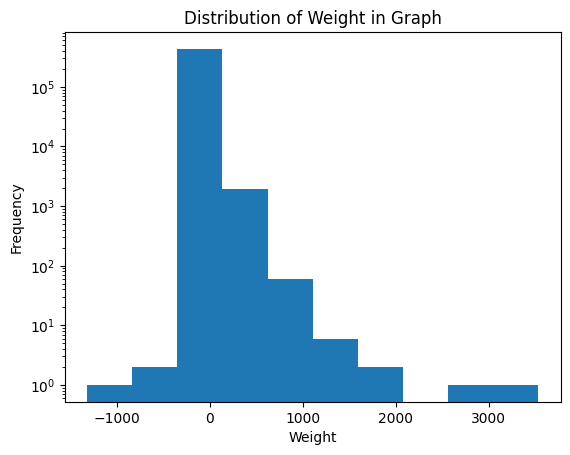

In [375]:
import matplotlib.pyplot as plt

# Extract weights from the graph
weights = [G[u][v]['weight'] for u, v in G.edges()]

# Plot the distribution of weights
plt.hist(weights , bins = 10, log = True )
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weight in Graph')
plt.show()

In [376]:
def non_negative_weights(graph):
  # Find the minimum weight in the graph
  min_weight = min(w for u, v, w in graph.edges(data='weight'))
  print(min_weight)
  # Check if there are negative weights
  # Adjust weights if there are negative values
  if min_weight < 0:
      adjustment = abs(min_weight) + 1
      for u, v in graph.edges():
          graph[u][v]['weight'] += adjustment

non_negative_weights(G)

-1320.0


In [377]:
# Store the original weights for correlation analysis
original_weights = {}
for u, v, weight in G.edges(data='weight'):
        if v not in original_weights:
            original_weights[v] = 0
        original_weights[v] += weight

# Extract PageRank scores and corresponding original weights
nodes = list(G.nodes)

original_weights_scores = [original_weights.get(0 , node ) for node in nodes]
#original_weights
all_users['weight'] = all_users['author_fullname'].map(original_weights).astype(float)

In [378]:
import networkx as nx
a = 0.85

# Handle dangling nodes (nodes with no out-links)
#dangling_weights = {n: 1.0 / len(G) for n in G if G.out_degree(n) == 0}

#pr=nx.pagerank(G, a , max_iter = 10000 ) #
pr=nx.pagerank(G, a , weight='weight', max_iter = 1000000 , tol=1e-6) #

In [379]:
all_users['pr'] = all_users['author_fullname'].map(pr).astype(float)
all_users['PageRank_Rank'] = all_users['pr'].rank(ascending=False)
#all_users['Karama_Rank'] = all_users['karama'].rank(ascending=False)
all_users['Karama_Rank'] = all_users['comments_score_sum'].rank(ascending=False)

In [380]:
# prompt: add column to all_users with multiple of comments karma * num comments

#all_users['karama_clac'] = ( all_users['comments_score_sum'] * 0.7 + all_users['count_unique_comment'] * 0.3 ) #+ ( all_users['post_score_sum'] * all_users['count_unique_posts'] )
#all_users['Karama_Rank'] = all_users['karama_clac'].rank(ascending=False)

In [381]:
hubs, authorities = nx.hits(G, max_iter = 1000000 , normalized = True)

all_users['hubs'] = all_users['author_fullname'].map(hubs) .astype(float)
all_users['authorities'] = all_users['author_fullname'].map(authorities) .astype(float)
all_users['Hubs_Rank'] = all_users['hubs'].rank(ascending=False)
all_users['Authorities_Rank'] = all_users['authorities'].rank(ascending=False)

In [382]:
all_users['weight'] = all_users['weight'].fillna(0)
all_users['Karama_Rank'] = all_users['weight'].rank(ascending=False)

In [383]:
from scipy.stats import spearmanr, kendalltau

# Calculating Spearman and Kendall correlations
spearman_pagerank_rho, p = spearmanr(all_users['PageRank_Rank'], all_users['Karama_Rank'])
kendall_pagerank_tau, _ = kendalltau(all_users['PageRank_Rank'], all_users['Karama_Rank'])

spearman_hubs_rho, p = spearmanr(all_users['Hubs_Rank'], all_users['Karama_Rank'])
kendall_hubs_tau, _ = kendalltau(all_users['Hubs_Rank'], all_users['Karama_Rank'])

spearman_authorities_rho, p = spearmanr(all_users['Authorities_Rank'], all_users['Karama_Rank'])
kendall_authorities_tau, _ = kendalltau(all_users['Authorities_Rank'], all_users['Karama_Rank'])

In [384]:
all_users.head()

,index,author_fullname,author_fullname_post,post_score_sum,count_unique_posts,author_fullname_comment_x,comments_score_sum,comments_score_sum_pos,count_unique_comment,count_unique_posts_asker,...,author_fullname_comment_y,score_comment_corr,weight,pr,PageRank_Rank,Karama_Rank,hubs,authorities,Hubs_Rank,Authorities_Rank
0,0,t2_7ogw5,t2_7ogw5,519610.0,315.0,t2_7ogw5,6.0,563.0,1.0,1.0,...,t2_7ogw5,6.0,1327.0,0.000007,11362.0,58421.0,2.488571e-05,2.498031e-06,17280.0,26850.0
1,1,t2_azskf4p,t2_azskf4p,266.0,2.0,t2_azskf4p,5.0,2790.0,5.0,2.0,...,t2_azskf4p,5.0,2647.0,0.000005,19046.0,37862.5,2.894449e-07,1.695367e-05,27620.0,16249.0
2,2,t2_c1qhwo8c,t2_c1qhwo8c,84.0,5.0,0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000003,165436.0,165436.0,5.744964e-05,1.459153e-18,1143.0,119319.0
3,3,t2_27zm0l8g,t2_27zm0l8g,264376.0,105.0,t2_27zm0l8g,104.0,26283.0,47.0,14.0,...,t2_27zm0l8g,104.0,18598.0,0.000022,1243.0,4143.0,7.391569e-05,4.187049e-05,2.0,2588.0
4,4,t2_zia33,t2_zia33,11.0,1.0,0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000003,165436.0,165436.0,2.635414e-08,7.874480e-19,34864.0,131237.0


In [385]:
all_users['Karama_Rank_Weight'] = all_users['weight'].rank(ascending=False)
all_users['Karama_Rank_score'] = all_users['comments_score_sum'].rank(ascending=False)

In [387]:
print( spearmanr((all_users['comments_score_sum']), (all_users['comments_score_sum_pos'])) )
print( kendalltau(( all_users['comments_score_sum']), (all_users['comments_score_sum_pos']) ))

print( spearmanr((all_users['pr']), (all_users['weight'])) )
print( kendalltau(( all_users['pr']), (all_users['weight']) ))
print( spearmanr((all_users['pr']), (all_users['comments_score_sum'])) )
print( kendalltau(( all_users['pr']), (all_users['comments_score_sum']) ))

print( spearmanr((all_users['Karama_Rank_score']), (all_users['PageRank_Rank'])) )
print( kendalltau(( all_users['Karama_Rank_score']), (all_users['PageRank_Rank']) ))

print( spearmanr(all_users['Karama_Rank_score'], all_users['Karama_Rank_Weight']) )
print( kendalltau(all_users['Karama_Rank_score'], all_users['Karama_Rank_Weight']) )

SignificanceResult(statistic=0.937610833358653, pvalue=0.0)
SignificanceResult(statistic=0.8758544655420356, pvalue=0.0)
SignificanceResult(statistic=0.9035893065985531, pvalue=0.0)
SignificanceResult(statistic=0.7581787867728544, pvalue=0.0)
SignificanceResult(statistic=0.8301026407230726, pvalue=0.0)
SignificanceResult(statistic=0.6784023822227719, pvalue=0.0)
SignificanceResult(statistic=0.8301026407230726, pvalue=0.0)
SignificanceResult(statistic=0.6784023822227718, pvalue=0.0)
SignificanceResult(statistic=0.945711827808173, pvalue=0.0)
SignificanceResult(statistic=0.8900611819162488, pvalue=0.0)


In [ ]:
all_users['calc_score'] = all_users['weight'] / ( all_users['count_unique_comment'] / all_users['count_unique_posts_asker']  )
all_users['calc_score'] = all_users['calc_score'].fillna(0)

In [ ]:
import matplotlib.pyplot as plt

# Extract weights from the graph
weights = all_users['weight']

# Plot the distribution of weights
plt.hist(weights , bins = 10, log = True )
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weight in Graph')
plt.show()

In [ ]:
print( spearmanr((all_users['comments_score_sum']), (all_users['calc_score'])) )
print( kendalltau(( all_users['comments_score_sum']), (all_users['calc_score']) ))

print( spearmanr((all_users['pr']), (all_users['calc_score'])) )
print( kendalltau(( all_users['pr']), (all_users['calc_score']) ))

In [ ]:
all_users['Rank_calc_score'] = all_users['calc_score'].rank(ascending=False)

In [ ]:
all_users.head()

In [ ]:
all_users['z_score'] = zscore( all_users['comments_score_sum'] )

In [ ]:
all_users.to_csv('users.csv')

In [ ]:
# Formatting results into a table
results = {
    'year' : [year],
    'year' : [year],
    'num nodes':[num_nodes],
    'num edges' : [num_edges],
    'a': [a],
    'ExpertRank_Spearman’s rho': [spearman_pagerank_rho],
    'ExpertRank_Kendall’s Tau': [kendall_pagerank_tau],
    'HITS Hubs_Spearman’s rho': [spearman_hubs_rho],
    'HITS Hubs_Kendall’s Tau': [kendall_hubs_tau],
    'HITS Auth_Spearman’s rho': [spearman_authorities_rho],
    'HITS Auth_Kendall’s Tau': [kendall_authorities_tau]
}

# Creating DataFrame
df_results = pd.DataFrame(results)

# Displaying the formatted DataFrame
df_results.head()

In [ ]:
all_users['Post_Rank'] = all_users['count_unique_posts'].rank(ascending=False)
print( spearmanr(all_users['Hubs_Rank'], all_users['Post_Rank']) )
print( kendalltau(all_users['Hubs_Rank'], all_users['Post_Rank']) )

In [ ]:
#all_users['PageRank_Rank'].head(20)
all_users['Karama_Rank'].head(20)

In [ ]:
all_users.loc[( all_users['comments_score_sum']== 0 )].head()

In [ ]:
all_users.loc[all_users['author_fullname'] == 't2_6wul2']

In [ ]:
edges_list_grouped.to_csv('edges.csv')

In [ ]:
all_users.to_csv(subrredit + '_users.csv')

In [ ]:
from scipy.stats import zscore

def z_score_normalization(ranks):
    return zscore(ranks)

# Example usage
all_users['PageRank_Rank'] = z_score_normalization(all_users['pr'])
all_users['Karama_Rank'] = z_score_normalization(all_users['comments_score_sum'])
all_users['Hubs_Rank'] = z_score_normalization(all_users['hubs'])
all_users['Authorities_Rank'] = z_score_normalization(all_users['authorities'])

#print("PageRank Z-Scores:", pagerank_z_scores)
#print("Comment Score Z-Scores:", comment_score_z_scores)


In [ ]:
#G.in_degree('Simulate_Me_Bot')
#print(G.edges('t2_6wul2'))
edge = pd.DataFrame(G.edges(data='weight'), columns = ['from', 'to', 'weight'] )

#print(sum( edge['weight']))
edge.head()

In [ ]:
# Get all edges to and from 't2_6wul2' with their weights
edges = G.edges('t2_6wul2', data='weight')

# Print the edges
print(edges)


In [ ]:
edge_list[(edge_list['author_fullname_comment'] == 'Simulate_Me_Bot') | (edge_list['author_fullname_post'] == 'Simulate_Me_Bot') ].to_csv('Simulate_Me_Bot.csv')

In [ ]:
merged_df[(merged_df['author_fullname_comment'] == 't2_9dvo687') & (merged_df['author_fullname_post'] == 't2_9dvo687') ]

In [ ]:
print(df_results.to_string(index=False))

In [ ]:
#df_results.to_csv()

In [ ]:
in_degrees = pd.DataFrame([( node , val) for (node, val) in G.in_degree()])
in_degrees.columns = ["node", "in_degrees"]
#in_degrees.loc[in_degrees["in_degrees"] <= 0]

out_degrees = pd.DataFrame([( node , val) for (node, val) in G.out_degree()])
out_degrees.columns = ["node", "out_degree"]
#out_degrees.loc[out_degrees["out_degree"] <= 0]

In [ ]:
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt

in_degree_counts = Counter(in_degrees["in_degrees"])
i_x, i_y = zip(*in_degree_counts.items())

plt.figure(figsize=(12, 8))

out_degree_counts = Counter(out_degrees["out_degree"])
o_x, o_y = zip(*out_degree_counts.items())

# prep axes
plt.xlabel('degree')
plt.xscale('log')
plt.xlim(1, max(o_x) )

plt.ylabel('frequency')
plt.yscale('log')
plt.ylim(1, max(o_y))
                                                                                                                                     # do plot
plt.scatter(i_x, i_y, marker='.', label ='in degree = Question')
plt.scatter(o_x, o_y, marker='*', label ='out degree = Answers')
plt.legend()
plt.show()

In [ ]:
all_users['authorities'].plot.hist( bins = 10, log = True )

In [ ]:
all_users['karama'].plot.hist( bins = 10, log = True )

In [ ]:
all_users['comments_score_sum'].plot.hist( bins = 10, log = True )

In [ ]:
all_users['weight'].plot.hist( bins = 10, log = True )

In [ ]:
all_users['pr'].plot.hist( bins = 10, log = True )

In [ ]:
all_users['hubs'].plot.hist( bins = 10, log = True )

In [ ]:
all_users['count_unique_posts'].plot.hist( bins = 10, log = True )

In [ ]:
# prompt: show table with num of comments and posts every year

import datetime as dt

# Convert the datetime_utc column to datetime objects
merged_df['datetime_utc_post'] = pd.to_datetime(merged_df['datetime_utc_post'])

# Extract the year from the datetime objects
merged_df['year'] = merged_df['datetime_utc_post'].dt.year

# Group the data by year and count the number of posts and comments
# Assuming merged_df is your DataFrame
grouped_df = merged_df.groupby('year').agg({
    'id_post': 'nunique',
    'id_comment': 'nunique'
}).rename(columns={
    'id_post': 'count_unique_posts',
    'id_comment': 'count_unique_comments'
})

# Rename the columns
grouped_df.columns = ['num_posts', 'num_comments']

# Print the table
print(grouped_df.to_string())

In [ ]:
posts_df.head()

In [ ]:
answers_first = comments_df.groupby("post_id")["datetime_utc"].min()
question_first_answer = pd.merge( posts_df , answers_first, how="left", left_on="id_x", right_on="post_id" , suffixes=('_post', '_comment'))
question_first_answer['time_to_answer'] = question_first_answer['datetime_utc_comment'] - question_first_answer['datetime_utc_post']


In [ ]:
sorted_df = comments_df.sort_values('datetime_utc')
sorted_df['datetime_utc'] = pd.to_datetime(sorted_df['datetime_utc'])

# Compute the differences on the sorted DataFrame
sorted_df['diff'] = sorted_df['datetime_utc'].diff()

sorted_df = sorted_df.reset_index()


In [ ]:
print(sorted_df['diff'].mean())
print( sorted_df['diff'].median())

In [ ]:
question_first_answer[['time_to_answer', 'datetime_utc_comment', 'datetime_utc_post']]


In [ ]:
#timeAverage(edge_list['time_to_answer'] , avg.time = "hour")
print( "avg time to answer")
print(question_first_answer['time_to_answer'].mean())
print( "median time to answer")
print(question_first_answer['time_to_answer'].median())
#edge_list.dtypes
print( "avg time a")
print( comments_df['datetime_utc'].sort_values().diff().mean() )
#posts_df['date_cr'] = pd.to_datetime(question_df['creation_date'])
print( "avg time q")
print( posts_df['datetime_utc'].sort_values().diff().mean() )
#.agg( {'avg_time_diff' : lambda group: group.sort_values().diff().mean()})
#print(full_df.loc[full_df["id_x"]!=full_df["accepted_answer_id_y"]]['time_to_answer'].median())

In [ ]:
sorted_df[['datetime_utc', 'diff']].sort_values('datetime_utc').head(20)#.diff()

In [ ]:
print(comments_df['datetime_utc'].sort_values().diff().mean())
print(comments_df['datetime_utc'].sort_values().diff().median())

In [ ]:
# Group the comments DataFrame by 'post_id' and count the comments for each post
comment_counts = comments_df.groupby('post_id')['id'].count()

# Add a new column 'num_comments' to the posts_df DataFrame
# Use a left join to match comment counts to post IDs, filling missing values with 0
posts_df = posts_df.merge(comment_counts, how='left', left_on='id', right_index=True).fillna(0)

# Rename the count column to 'num_comments'
posts_df = posts_df.rename(columns={'id_comment': 'num_comments'})

# Convert 'num_comments' column to integer type
posts_df['num_comments'] = posts_df['num_comments'].astype(int)

# prompt: show table with num of comments and posts every year

import datetime as dt

# Convert the datetime_utc column to datetime objects
posts_df['datetime_utc'] = pd.to_datetime(posts_df['datetime_utc'])

# Extract the year from the datetime objects
posts_df['year'] = posts_df['datetime_utc'].dt.year



In [ ]:
print( "avg time to answer")
print(question_first_answer['time_to_answer'].mean())
print( "median time to answer")
print(question_first_answer['time_to_answer'].median())

question_first_answer['datetime_utc_post'] = pd.to_datetime(question_first_answer['datetime_utc_post'], errors='coerce')

question_first_answer['year'] = question_first_answer['datetime_utc_post'].dt.year

grouped_df = question_first_answer.groupby('year').agg({
    'id_x': 'nunique',
    'num_comments': ['mean', 'sum'],
    'time_to_answer' : ['mean', 'median']

})

# Rename the columns
#grouped_df.columns = ['num_posts', 'num_comments','avg_comments']

# Print the table
grouped_df

In [ ]:
valid_question_first_answer = question_first_answer['datetime_utc_comment'].dropna()
grouped_df = question_first_answer.groupby('year').agg({
    'id': 'nunique',
    'num_comments': ['mean', 'sum'],
    'time_to_answer' : ['mean', lambda x: x.median(skipna=True)]

})

grouped_df.head(20)

In [ ]:
question_first_answer[['datetime_utc_post', 'datetime_utc_comment', 'time_to_answer']].head(10)

In [ ]:
# Group the data by year and count the number of posts and comments
# Assuming merged_df is your DataFrame
grouped_df = posts_df.groupby('year').agg({
    'id': 'nunique',
    'num_comments': ['sum', 'mean']
})

# Rename the columns
#grouped_df.columns = ['num_posts', 'num_comments','avg_comments']

# Print the table
grouped_df

In [ ]:
all_users.to_csv('uses_1.csv')

In [ ]:
# prompt: plot correletion of karama rank and pagerank rank

import matplotlib.pyplot as plt
import seaborn as sns
# Extract the relevant columns from all_users
karama_rank = all_users['Karama_Rank']
pagerank_rank = all_users['PageRank_Rank']
correlation = all_users['Karama_Rank'].corr(all_users['PageRank_Rank'])
print(f"Correlation between field1 and field2: {correlation:.4f}")

# Plot correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_users, x='Karama_Rank', y='PageRank_Rank')
plt.title('Correlation between Field1 and Field2')
plt.xlabel('Karama_Rank')
plt.ylabel('PageRank_Rank')
plt.grid(True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the data loaded in a DataFrame df with columns 'Karama_Rank' and 'PageRank_Rank'
df = all_users  # Load your data file

# Calculate correlation
correlation = df['Karama_Rank'].corr(df['PageRank_Rank'])
print(f"Correlation between Karama_Rank and PageRank_Rank: {correlation:.4f}")

# Create histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Karama_Rank'], bins=50, kde=True)
plt.title('Distribution of Karama_Rank')

plt.subplot(1, 2, 2)
sns.histplot(df['PageRank_Rank'], bins=50, kde=True)
plt.title('Distribution of PageRank_Rank')

plt.tight_layout()
plt.show()
